In [183]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import QuantileRegressor

iris = datasets.load_iris()

#1 - Importation et analyse descriptive des données

In [191]:
X = iris.data
y = iris.target

In [185]:
features = iris.feature_names
print(features)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


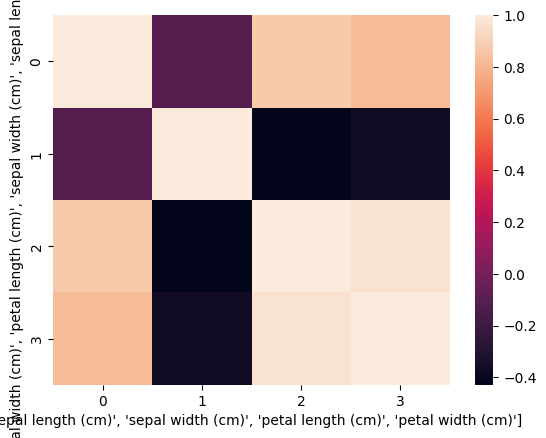

In [83]:
import seaborn as sns
sns.heatmap(np.corrcoef(X.T))
plt.xlabel(features)
features.reverse()
plt.ylabel(features)
plt.show()
features.reverse()

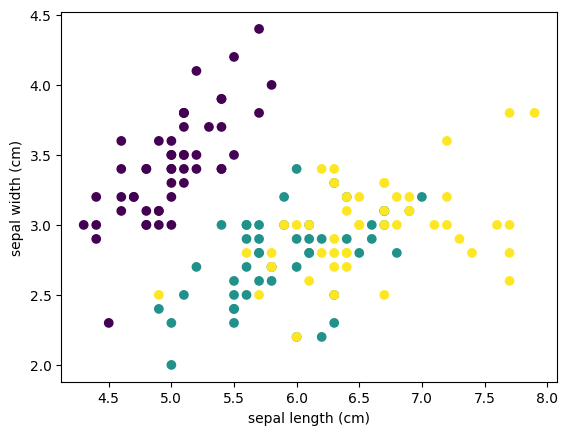

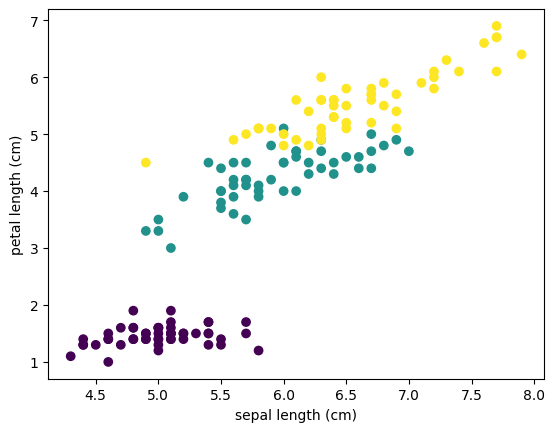

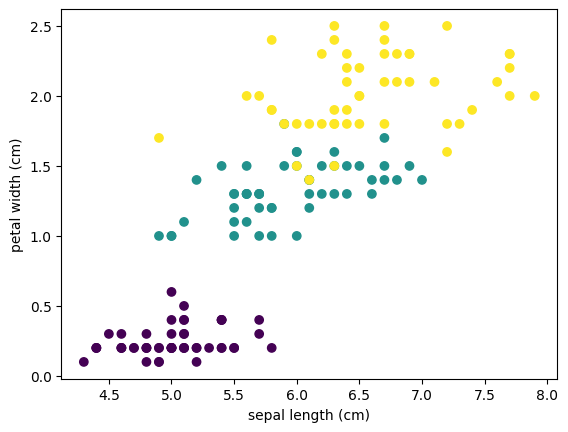

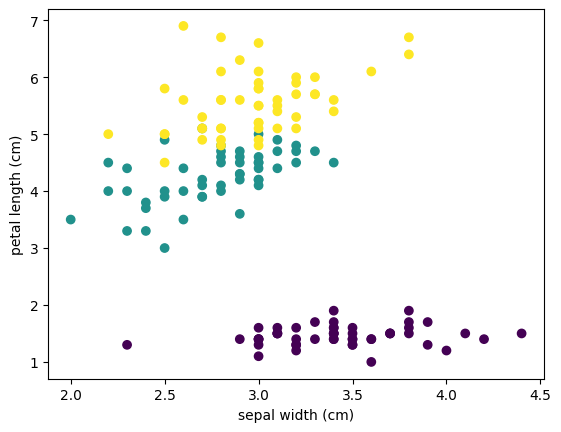

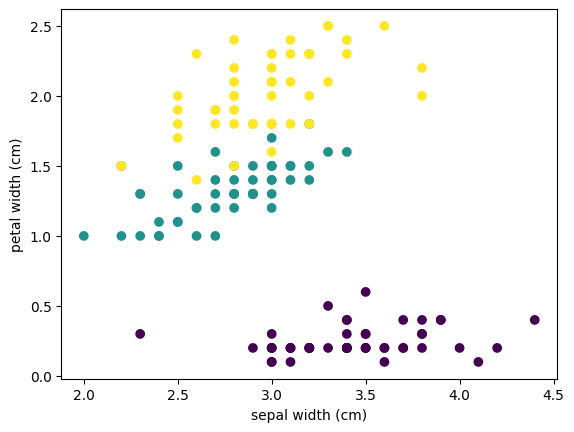

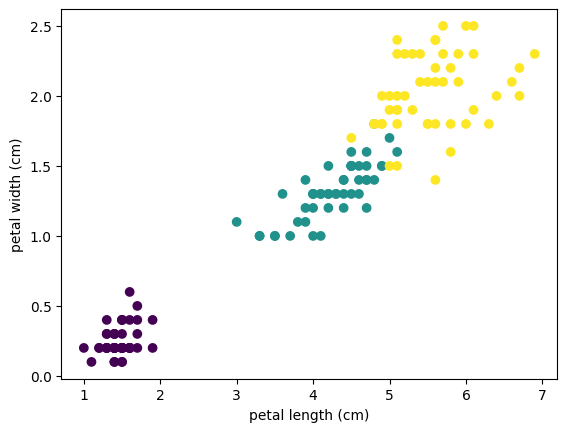

In [84]:
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.scatter(X[:,i], X[:,j], c=y)
        plt.xlabel(features[i])
        plt.ylabel(features[j])
        plt.show()

# 2 - Implémentation SCP
On va modéliser Petal Width fonction de Petal Length. Le plot permets de voir qu'il semble exister une relation linéaire entre les deux.

## SCP non-adaptative

In [142]:
#Je sépare mon jeu de données en train, calib, test

X_train1, X_test, y_train1, y_test = train_test_split(X[:,-1:],X[:,-2:-1], test_size=0.1)
X_train, X_calib, y_train, y_calib = train_test_split(X_train1, y_train1, test_size=0.5)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

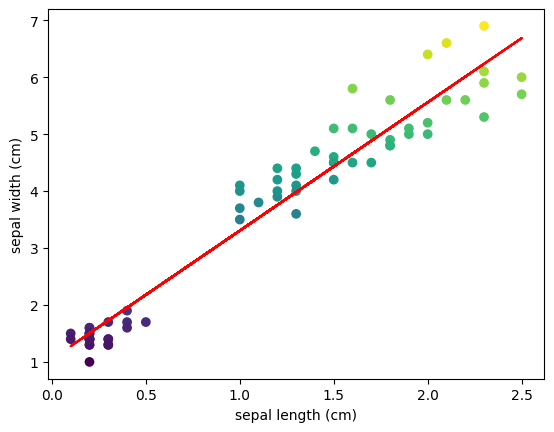

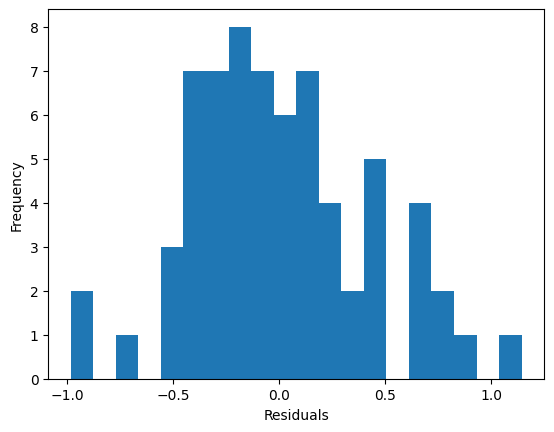

In [86]:
plt.scatter(X_train, y_train[:,-1], c=y_train)
plt.plot(X_train[:,0], model.predict(X_train), color='red')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

plt.hist(y_train-model.predict(X_train), bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [87]:
def score(X, Y, model, score_func = "SE"):
  if score_func == "SE":
    return np.linalg.norm(Y-model.predict(X),axis = 1)**2
  else:
    return np.abs(Y-model.predict(X))

In [88]:
alpha = 0.1

N_calib = (X_calib.shape[0] + 1) / X_calib.shape[0]

quantile_S = np.quantile(score(X_calib, y_calib, model, score_func = "AE"), (1 -alpha) * N_calib)
quantile_S

np.float64(0.8655334562577707)

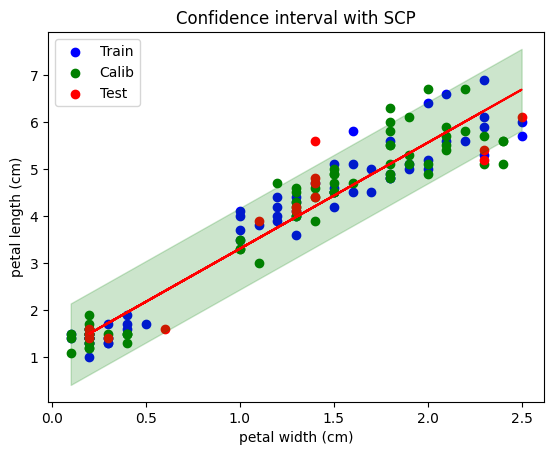

In [89]:
x_inter = np.linspace(np.min(X[:,-1]), np.max(X[:,-1]), 100)
X_inter = x_inter[:,None]

plt.scatter(X_train, y_train[:,-1], c="b")
plt.scatter(X_calib, y_calib[:,-1], c="g")
plt.scatter(X_test, y_test[:,-1], c="r")
plt.plot(X_test[:,0], model.predict(X_test), color='red')
plt.fill_between(x_inter, model.predict(X_inter)[:,0] - quantile_S, model.predict(X_inter)[:,0] + quantile_S, color='green', alpha=0.2)
plt.xlabel(features[-1])
plt.ylabel(features[-2])
plt.title("Confidence interval with SCP")
plt.legend(["Train","Calib","Test"])
plt.show()

In [90]:
coverage_train = np.mean((y_train > model.predict(X_train)-quantile_S) & (y_train < model.predict(X_train)+quantile_S))
coverage_calib = np.mean((y_calib > model.predict(X_calib)-quantile_S) & (y_calib < model.predict(X_calib)+quantile_S))
coverage_test = np.mean((y_test > model.predict(X_test)-quantile_S) & (y_test < model.predict(X_test)+quantile_S))

print(f"Coverage for train: {coverage_train}")
print(f"Coverage for calib: {coverage_calib}")
print(f"Coverage for test: {coverage_test}")

Coverage for train: 0.9552238805970149
Coverage for calib: 0.9117647058823529
Coverage for test: 0.8666666666666667


## SCP avec adaptativité

On va créer 2 des 3 fonctions u présentes dans les slides

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


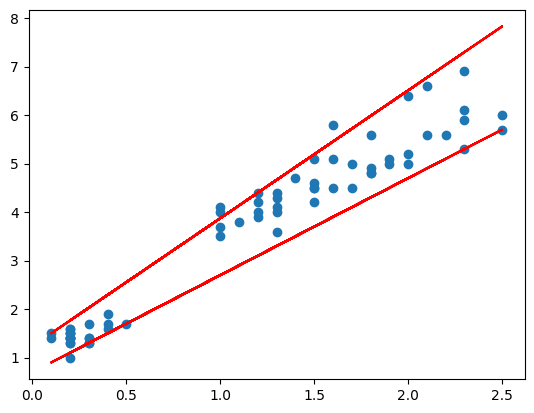

In [130]:
quant_down = QuantileRegressor(quantile=0.05, alpha = 0)
quant_down.fit(X_train, y_train)
quant_up = QuantileRegressor(quantile=0.95, alpha = 0)
quant_up.fit(X_train, y_train)

plt.plot(X_train[:,0], quant_down.predict(X_train).ravel(), color='red', )
plt.plot(X_train[:,0], quant_up.predict(X_train).ravel(), color='red')
plt.scatter(X_train[:,0], y_train[:,0])

In [138]:

def u_VC(x, model = None):
  return quant_up.predict(x) - quant_down.predict(x)

def u_VP(x, model = None):
  vars = np.zeros(x.shape[0])
  for i in range(x.shape[0]):
    vars[i] = model.predict(np.random.normal(loc= 0, scale = 0.2,size = (1000,1))+x[i]).var()
  return vars


def score_adapt(X, Y, model, u, score_func = "SE"):
  if score_func == "SE":
    return np.linalg.norm(Y-model.predict(X),axis = 1)**2/u(X,model)
  else:
    return np.abs(Y-model.predict(X))/u(X,model)

In [139]:
alpha = 0.1

N_calib = (X_calib.shape[0] + 1) / X_calib.shape[0]

quantile_S = np.quantile(score_adapt(X_calib, y_calib, model,u_VP, score_func = "AE"), (1 -alpha) * N_calib)
quantile_S

np.float64(4.376853158873586)

In [140]:
x_inter = np.linspace(np.min(X[:,-1]), np.max(X[:,-1]), 100)[:,None]
y_up = model.predict(x_inter)+quantile_S*u_VP(x_inter,model)[:,None]
y_down = model.predict(x_inter)-quantile_S*u_VP(x_inter,model)[:,None]

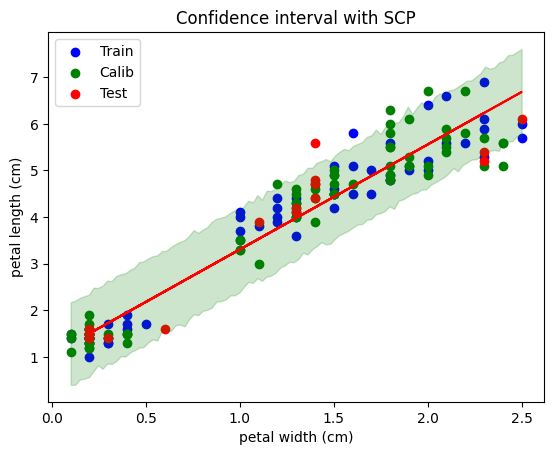

In [141]:
plt.scatter(X_train, y_train[:,-1], c="b")
plt.scatter(X_calib, y_calib[:,-1], c="g")
plt.scatter(X_test, y_test[:,-1], c="r")
plt.plot(X_test[:,0], model.predict(X_test), color='red')
plt.fill_between(x_inter[:,0], y_down[:,0], y_up[:,0], color='green', alpha=0.2)
plt.xlabel(features[-1])
plt.ylabel(features[-2])
plt.title("Confidence interval with SCP")
plt.legend(["Train","Calib","Test"])
plt.show()

In [136]:
y_up_train = model.predict(X_train)+quantile_S*u_VP(X_train,model)[:,None]
y_down_train = model.predict(X_train)-quantile_S*u_VP(X_train,model)[:,None]
coverage_train = np.mean((y_train > y_down_train) & (y_train < y_up_train))

y_up_calib = model.predict(X_calib)+quantile_S*u_VP(X_calib,model)[:,None]
y_down_calib = model.predict(X_calib)-quantile_S*u_VP(X_calib,model)[:,None]

coverage_calib = np.mean((y_calib > y_down_calib) & (y_calib < y_up_calib))

y_up_test = model.predict(X_test)+quantile_S*u_VP(X_test,model)[:,None]
y_down_test = model.predict(X_test)-quantile_S*u_VP(X_test,model)
coverage_test = np.mean((y_test > y_down_test) & (y_test < y_up_test))

print(f"Coverage for train: {coverage_train}")
print(f"Coverage for calib: {coverage_calib}")
print(f"Coverage for test: {coverage_test}")

Coverage for train: 0.9701492537313433
Coverage for calib: 0.9411764705882353
Coverage for test: 0.8133333333333334


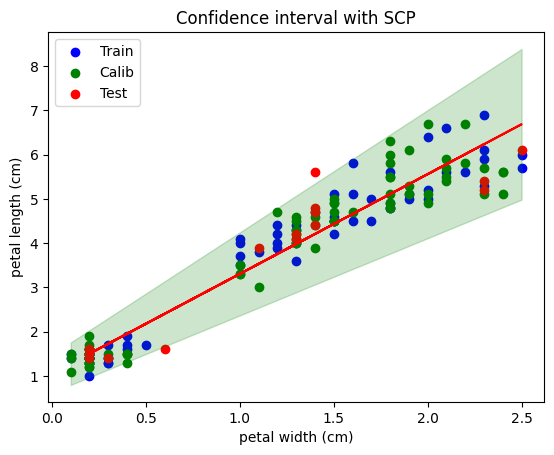

In [137]:
quantile_S = np.quantile(score_adapt(X_calib, y_calib, model,u_VC, score_func = "AE"), (1 -alpha) * N_calib)
y_up = model.predict(x_inter)+quantile_S*u_VC(x_inter,model)[:,None]
y_down = model.predict(x_inter)-quantile_S*u_VC(x_inter,model)[:,None]

plt.scatter(X_train, y_train[:,-1], c="b")
plt.scatter(X_calib, y_calib[:,-1], c="g")
plt.scatter(X_test, y_test[:,-1], c="r")
plt.plot(X_test[:,0], model.predict(X_test), color='red')
plt.fill_between(x_inter[:,0], y_down[:,0], y_up[:,0], color='green', alpha=0.2)
plt.xlabel(features[-1])
plt.ylabel(features[-2])
plt.title("Confidence interval with SCP")
plt.legend(["Train","Calib","Test"])
plt.show()

# FCP pour classification

On va utiliser un modèle pas trop puissant : la random forest (cf https://archive.ics.uci.edu/dataset/53/iris )

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [193]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100)
def score_classif(X, Y, model, score_func = 0):
  if score_func == 0:
    return 1 - model.predict_proba(X)[np.arange(X.shape[0]),y]
  else:
    prob_dec = model.predict_proba(X).argsort(1)[:,::-1]
    prob_srt = np.take_along_axis(model.predict_proba(X),prob_dec,axis = 1)
    prob_rank_true = np.where(prob_dec == Y[:,None])[1]
    return prob_srt.cumsum(axis=1)[np.arange(X.shape[0]),prob_rank_true]

RF.fit(X_train, y_train)

def inclusion_y(X_train, Y_train, x_new, y, alpha, model, score_func = 0):
  X_train_y = np.vstack((X_train, x_new))
  Y_train_y = np.hstack((Y_train, y))
  predicteur = model.fit(X_train_y, Y_train_y)
  scores = score_classif(X_train_y, Y_train_y, predicteur, score_func = 0)
  if score_classif(x_new, y, predicteur, score_func = score_func) < np.quantile(scores, 1-alpha):
    return True
  else:
    return False

In [199]:
# pour un X_test :
from time import time

start = time()

for y in range(3):
  decision = inclusion_y(X_train, y_train, X_test[0:1], np.array([y]), 0.1, RF, score_func = 1)
  print(decision)

print(time()-start)

False
True
True
1.9161930084228516
